In [ ]:
!pip install scipy

<h1> Introduction </h1>

A firewall acts as security guard controlling access between an internal, protected network and an external, untrusted netwrok based on a given security policy. Besides preventing intruders from getting in, a firewall also helps prevent confedential inside data from going out.

The main functions of a firewall are  -

A fiewall filters incoming (from Internet to organization) and outgoing (from withing organization to outside) packets. A firewall is configured with a ruleset which decided which packets to let in and which ones to drop.

-----------------------------------------------------------------


Based on this there are four actions -----------

Allow -> Let the connection procees

Deny -> Block the traffic

Drop -> Discard the packet with no response

Reset-both -> Send TCP RST to both the parties

------------------------------------------------------------------

What is NAT ?

Publicly accessible machines within an organization such as web server may or may not have public Internet address. In case when they do not have public internet address it is possible to conceal the addressing schema on these machines from the outside world though NAT. Through NAT though not visible on the Internet can establish communcation with the outside machines on the Internet. Network address translation is usally done by the firewalls.






<h1> Problem Statement </h1>

If a person wants to access a prohibited website on the
network , the firewall should be able to block that
particular website on the network.

Cosnidering that Internet is ever expanding, it can be a diffult to continously update the access list by the admin.

As log reports are also an integral part of the firewall system, we utilise the data from these log reports and decide wheather the underlying traffic must be allowed.

<h1> Steps taken to solve </h1>

Data sourced from - https://www.kaggle.com/datasets/tunguz/internet-firewall-data-set

Given the network log, classify if the underlying traffic can be allowed.


1. First EDA of the given data is done, to get a good understanding of the ranges and distribution

2. Based on the given features, new features are extracted and some given features are dropped.

3. Once necessary encoding strategies are applied on the final feature set, they are applied on various models.

4. Intially a random model that arbitarily assigns probabilty scores and then various other models are built that are then compared against one another based on the performance metrics.


Given that this problem requires the devlopment of a low latency application, the model must be able to make fats predictions and ensure no hinderance in the operations.



In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import log_loss,confusion_matrix
from scipy import sparse
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [143]:
firewall_data  = pd.read_csv("/content/drive/MyDrive/Problems/Internet_Firewall/log2.csv")

In [144]:
firewall_data.shape

(65532, 12)

In [145]:
firewall_data.head()


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [146]:
#removing space from column names and converting to lower case characters for easy access of column names
firewall_data.columns = firewall_data.columns.str.replace(' ','_')
firewall_data.columns = firewall_data.columns.str.lower()

In [147]:
#understanding the memory consumption and data type of column names
firewall_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   source_port           65532 non-null  int64 
 1   destination_port      65532 non-null  int64 
 2   nat_source_port       65532 non-null  int64 
 3   nat_destination_port  65532 non-null  int64 
 4   action                65532 non-null  object
 5   bytes                 65532 non-null  int64 
 6   bytes_sent            65532 non-null  int64 
 7   bytes_received        65532 non-null  int64 
 8   packets               65532 non-null  int64 
 9   elapsed_time_(sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 9.3 MB


In [148]:
#get he count of each class label in the dataset
firewall_data['action'].value_counts(dropna = False)

,count
action,
allow,37640
deny,14987
drop,12851
reset-both,54


In [149]:
print("number of null values ",firewall_data.isnull().sum())

number of null values  source_port             0
destination_port        0
nat_source_port         0
nat_destination_port    0
action                  0
bytes                   0
bytes_sent              0
bytes_received          0
packets                 0
elapsed_time_(sec)      0
pkts_sent               0
pkts_received           0
dtype: int64


<h2> Exploratory Data Analysis </h2>

Note :

1. Excess kurtosis measures how much deviated the curve is from the
   gaussian curve.
2. Excess Kurtosis = Kurtosis - 3
3. Here, 3 is the kurtosis of  the Gaussian distribution

<h4> Understanding the distribution of packets,bytes and time elapsed parameters

<Axes: xlabel='bytes', ylabel='Density'>

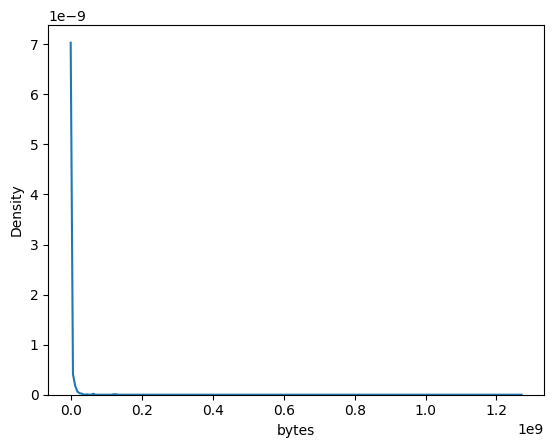

In [151]:
sns.distplot(firewall_data['bytes'],hist = False)

In [153]:
from scipy.stats import kurtosis

excess_kurt = kurtosis(firewall_data['bytes'].values)
print("the excess kurtosis of the bytes data is ",excess_kurt)

the excess kurtosis of the bytes data is  40466.966188974126


<h3> Conclusion </h3>

1. From the pdf curve of the bytes data we can see that the curve is very
   peaked at one point and right tailed which implies the presence of outliers.

2. For this the excess kurtosis of the curve is measured which is found to
   be 40466


<Axes: xlabel='packets', ylabel='Density'>

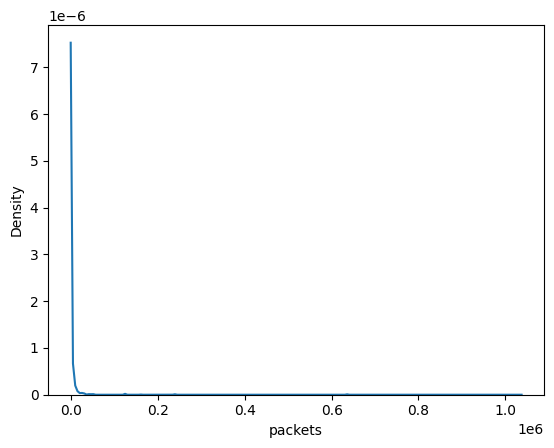

In [10]:
sns.distplot(firewall_data['packets'],hist = False)

In [11]:
from scipy.stats import kurtosis

excess_kurt = kurtosis(firewall_data['packets'].values)
print(excess_kurt)

29085.772032506597


<h3> Conclusion </h3>

1. From the pdf curve of the packets data we can see that the curve is
   very peaked at one point and right tailed which implies the presence of outliers.
   
2. For this the excess kurtosis of the curve is measured which is found to
   be 29085.7

<Axes: xlabel='elapsed_time_(sec)', ylabel='Density'>

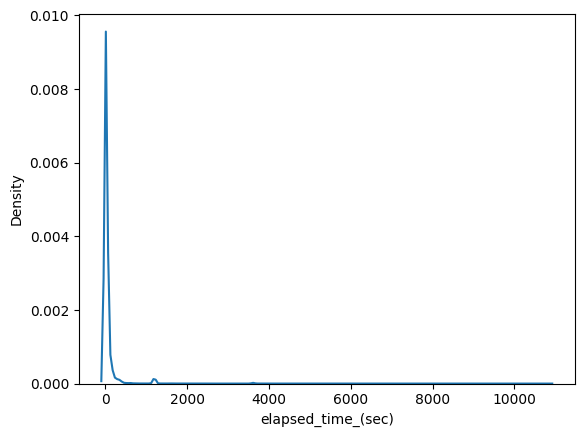

In [12]:
sns.distplot(firewall_data['elapsed_time_(sec)'],hist = False)

In [13]:
from scipy.stats import kurtosis

excess_kurt = kurtosis(firewall_data['elapsed_time_(sec)'].values)
print(excess_kurt)

221.26827784217497


<h3> Conclusion </h3>

  1. From the pdf curve of the elapsed time data we can see that the curve
     is very peaked around 0 to 1000 seconds and right tailed later which implies the presence of outliers.

  2. For this the excess kurtosis of the curve is measured which is found to
   be 221.

<h3> Handling Outliers </h3>

Here we compute the percentile values from 90th to 100th percentile.
Then the percetile values are further drilled down 99th to 100th percentile
with a step size of 0.1

In [14]:
for i in range(90,101,1):
  print(i,"th percentile value is ",round(np.percentile(firewall_data['bytes'],i),2))

print()
print("*"*40)
print()

percentile = 99.0
while percentile <= 100.0:
  print(percentile,"th percentile value is ",round(np.percentile(firewall_data['bytes'],percentile),2))
  percentile += 0.1
  percentile = round(percentile,1)

90 th percentile value is  8007.0
91 th percentile value is  8820.21
92 th percentile value is  9841.52
93 th percentile value is  11485.83
94 th percentile value is  14558.14
95 th percentile value is  20411.45
96 th percentile value is  32218.16
97 th percentile value is  64387.47
98 th percentile value is  152192.66
99 th percentile value is  520001.89
100 th percentile value is  1269359015.0

****************************************

99.0 th percentile value is  520001.89
99.1 th percentile value is  613369.96
99.2 th percentile value is  763581.38
99.3 th percentile value is  962215.15
99.4 th percentile value is  1212436.16
99.5 th percentile value is  1784576.91
99.6 th percentile value is  2766525.14
99.7 th percentile value is  4631089.51
99.8 th percentile value is  7978355.01
99.9 th percentile value is  13758558.11
100.0 th percentile value is  1269359015.0


In [ ]:
for i in range(90,101,1):
  print(i,"th percentile value is ",round(np.percentile(firewall_data['packets'],i),2))

print()
print("*"*40)
print()

percentile = 99.0
while percentile <= 100.0:
  print(percentile,"th percentile value is ",round(np.percentile(firewall_data['packets'],percentile),2))
  percentile += 0.1
  percentile = round(percentile,1)

90 th percentile value is  25.0
91 th percentile value is  28.0
92 th percentile value is  31.0
93 th percentile value is  36.0
94 th percentile value is  41.14
95 th percentile value is  50.0
96 th percentile value is  65.0
97 th percentile value is  102.0
98 th percentile value is  209.38
99 th percentile value is  627.0
100 th percentile value is  1036116.0

****************************************

99.0 th percentile value is  627.0
99.1 th percentile value is  752.22
99.2 th percentile value is  897.75
99.3 th percentile value is  1099.57
99.4 th percentile value is  1348.51
99.5 th percentile value is  1938.45
99.6 th percentile value is  2921.02
99.7 th percentile value is  4509.81
99.8 th percentile value is  7608.44
99.9 th percentile value is  12518.29
100.0 th percentile value is  1036116.0


In [ ]:
for i in range(90,101,1):
  print(i,"th percentile value is ",round(np.percentile(firewall_data['elapsed_time_(sec)'],i),2))

print()
print("*"*40)
print()

percentile = 99.0
while percentile <= 100.0:
  print(percentile,"th percentile value is ",round(np.percentile(firewall_data['elapsed_time_(sec)'],percentile),2))
  percentile += 0.1
  percentile = round(percentile,1)

90 th percentile value is  113.0
91 th percentile value is  121.0
92 th percentile value is  130.0
93 th percentile value is  139.0
94 th percentile value is  158.0
95 th percentile value is  194.0
96 th percentile value is  256.0
97 th percentile value is  345.0
98 th percentile value is  807.76
99 th percentile value is  1200.0
100 th percentile value is  10824.0

****************************************

99.0 th percentile value is  1200.0
99.1 th percentile value is  1200.0
99.2 th percentile value is  1200.0
99.3 th percentile value is  1200.0
99.4 th percentile value is  1201.0
99.5 th percentile value is  1351.35
99.6 th percentile value is  1899.4
99.7 th percentile value is  3591.88
99.8 th percentile value is  3609.0
99.9 th percentile value is  3832.69
100.0 th percentile value is  10824.0


<h3> Conclusion </h3>

The 100th percetile values of bytes,packets and time elpased is found to be very large when compared to the other percentile values.

Hence we will go ahead with removing this from our data

In [154]:
firewall_data = firewall_data[firewall_data.bytes < np.percentile(firewall_data['bytes'],100)]
firewall_data = firewall_data[firewall_data.packets < np.percentile(firewall_data['packets'],100)]
firewall_data = firewall_data[firewall_data['elapsed_time_(sec)'] < np.percentile(firewall_data['elapsed_time_(sec)'],100)]

In [155]:
firewall_data.shape

(65529, 12)

In [17]:
#divide the data into four dataframes based on the class label

allow_df = firewall_data[firewall_data.action == 'allow']
deny_df = firewall_data[firewall_data.action == 'deny']
drop_df = firewall_data[firewall_data.action == 'drop']
reset_df = firewall_data[firewall_data.action == 'reset-both']

Looking up the 50th percentile or the median value of bytes and packets for all the 4 class types

In [18]:

print("Median value of total bytes when action is allow ",allow_df.bytes.median())
print("Median value of total packets when action is allow ",allow_df.packets.median())
print("*"*20)
print("Median value of total bytes when action is deny ",deny_df.bytes.median())
print("Median value of total packets when action is deny ",deny_df.packets.median())
print("*"*20)
print("Median value of total bytes when action is drop ",drop_df.bytes.median())
print("Median value of total packets when action is drop ",drop_df.packets.median())
print("*"*20)
print("Median value of total bytes when action is reset-both ",reset_df.bytes.median())
print("Median value of total packets when action is reset-both ",reset_df.packets.median())
print("*"*20)

Median value of total bytes when action is allow  422.0
Median value of total packets when action is allow  3.0
********************
Median value of total bytes when action is deny  66.0
Median value of total packets when action is deny  1.0
********************
Median value of total bytes when action is drop  70.0
Median value of total packets when action is drop  1.0
********************
Median value of total bytes when action is reset-both  145.0
Median value of total packets when action is reset-both  1.0
********************


<h3> We will look up the CDF plots of packets,bytes and elapsed time for each of the four classes </h3>

<Axes: title={'center': 'ALLOW'}, xlabel='bytes', ylabel='Density'>

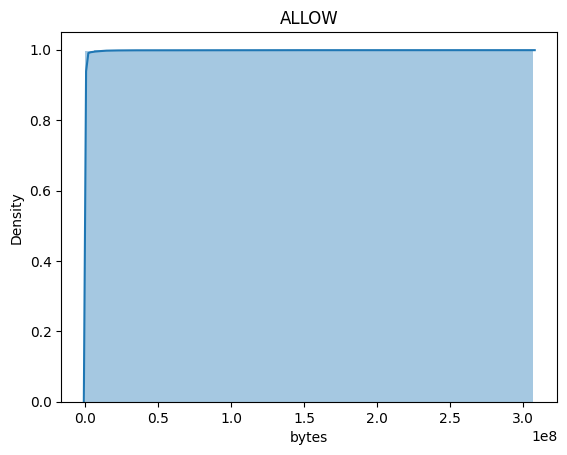

In [159]:

# ax1 = sns.distplot(allow_df.bytes)
plt.title("ALLOW")
kwargs = {'cumulative': True}
sns.distplot(allow_df.bytes, hist_kws=kwargs, kde_kws=kwargs)



<Axes: title={'center': 'DENY'}, xlabel='bytes', ylabel='Density'>

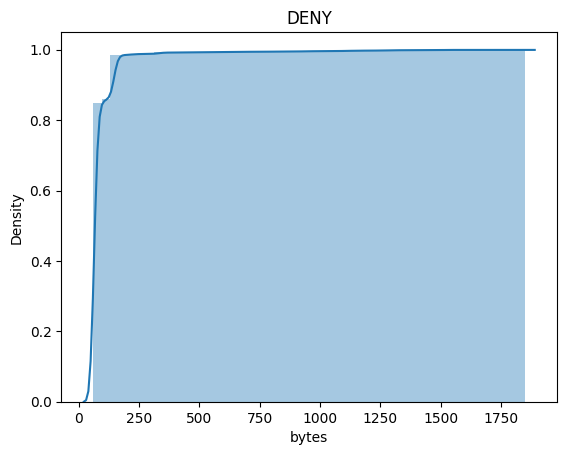

In [160]:


plt.title("DENY")
# ax1 = sns.distplot(deny_df.bytes)
kwargs = {'cumulative': True}
sns.distplot(deny_df.bytes, hist_kws=kwargs, kde_kws=kwargs)



<Axes: title={'center': 'DROP'}, xlabel='bytes', ylabel='Density'>

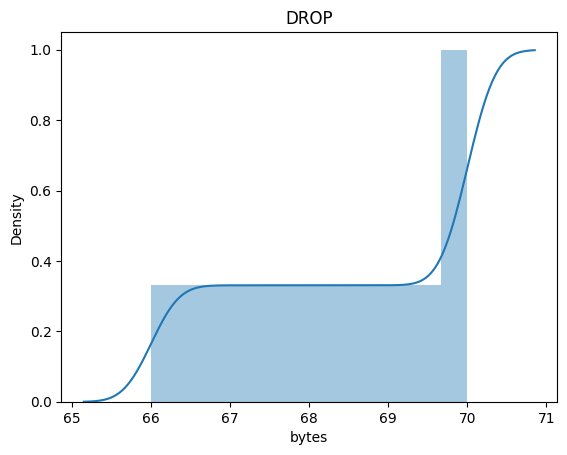

In [161]:
# plt.title("ACTION : DROP")

plt.title("DROP")
# ax1 = sns.distplot(drop_df.bytes)
kwargs = {'cumulative': True}
sns.distplot(drop_df.bytes, hist_kws=kwargs, kde_kws=kwargs)



<Axes: title={'center': 'RESET-BOTH'}, xlabel='bytes', ylabel='Density'>

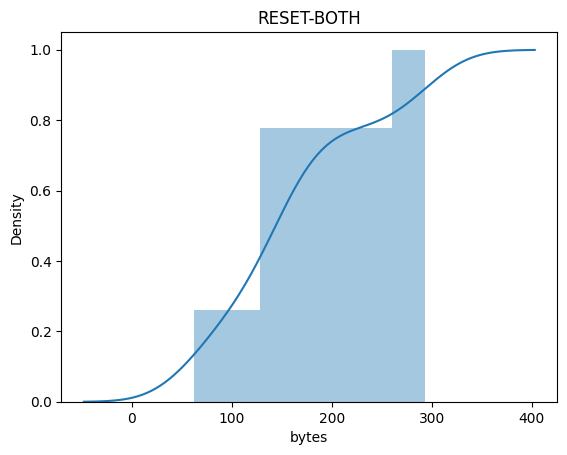

In [162]:
# plt.title("ACTION : RESET-BOTH")

plt.title("RESET-BOTH")
# ax1 = sns.distplot(reset_df.bytes)
kwargs = {'cumulative': True}
sns.distplot(reset_df.bytes, hist_kws=kwargs, kde_kws=kwargs)


<Axes: title={'center': 'ALLOW'}, xlabel='packets', ylabel='Density'>

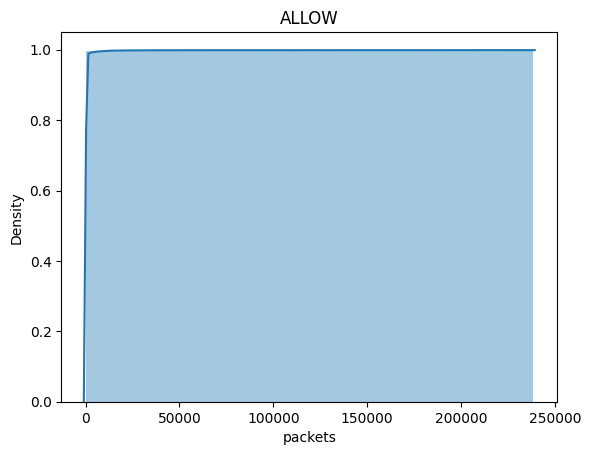

In [163]:


plt.title("ALLOW")
# ax1 = sns.distplot(allow_df.packets)
kwargs = {'cumulative': True}
sns.distplot(allow_df.packets, hist_kws=kwargs, kde_kws=kwargs)

# plt.subplot(1,2,2)
# sns.set()
# ax1 = sns.distplot(allow_df.pkts_received)
# kwargs = {'cumulative': True}
# sns.distplot(allow_df.pkts_received, hist_kws=kwargs, kde_kws=kwargs)

<Axes: title={'center': 'DENY'}, xlabel='packets', ylabel='Density'>

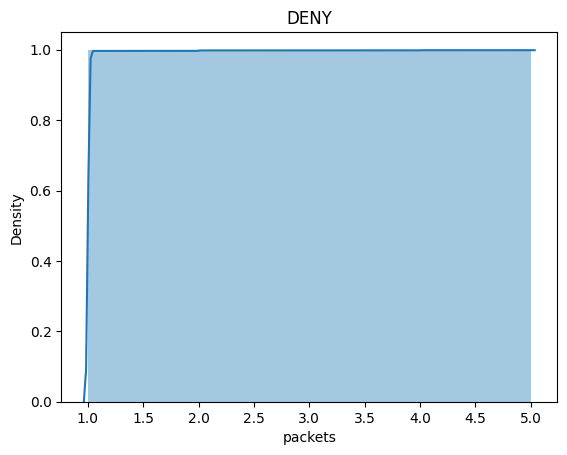

In [164]:
# plt.subplot(1,3,1)
# sns.set()
# ax = sns.distplot(deny_df.packets)
# kwargs = {'cumulative': True}
# sns.distplot(deny_df.packets, hist_kws=kwargs, kde_kws=kwargs)

plt.title("DENY")
# ax1 = sns.distplot(deny_df.packets)
kwargs = {'cumulative': True}
sns.distplot(deny_df.packets, hist_kws=kwargs, kde_kws=kwargs)



<Axes: title={'center': 'DROP'}, xlabel='packets', ylabel='Density'>

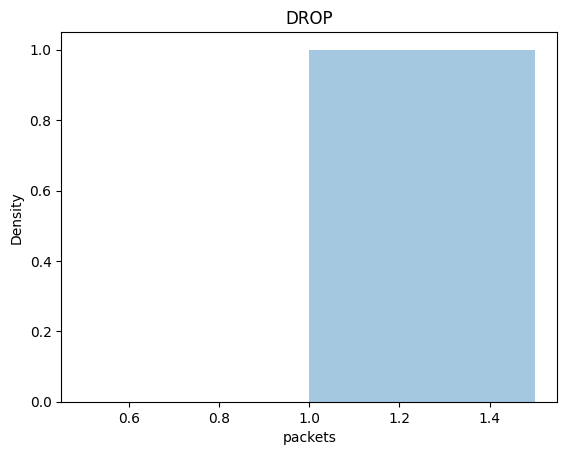

In [165]:
# plt.subplot(1,3,1)
# sns.set()
# ax = sns.distplot(drop_df.packets)
# kwargs = {'cumulative': True}
# sns.distplot(drop_df.packets, hist_kws=kwargs, kde_kws=kwargs)

plt.title("DROP")
# ax1 = sns.distplot(drop_df.packets)
kwargs = {'cumulative': True}
sns.distplot(drop_df.packets, hist_kws=kwargs, kde_kws=kwargs)


<Axes: title={'center': 'RESET-BOTH'}, xlabel='packets', ylabel='Density'>

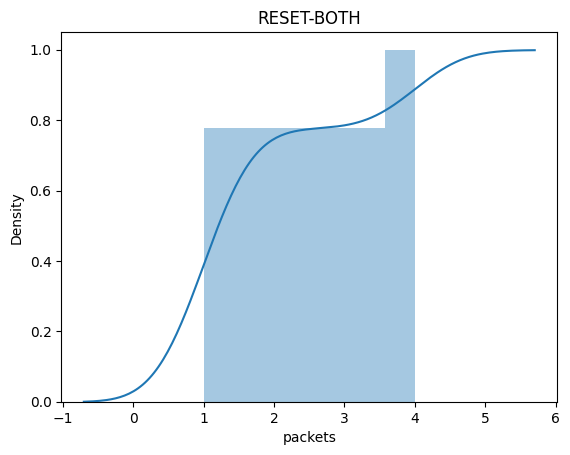

In [166]:
# plt.subplot(3,1,1)
# sns.set()
# ax = sns.distplot(reset_df.packets)
# kwargs = {'cumulative': True}
# sns.distplot(reset_df.packets, hist_kws=kwargs, kde_kws=kwargs)
plt.title("RESET-BOTH")
# ax1 = sns.distplot(reset_df.packets)
kwargs = {'cumulative': True}
sns.distplot(reset_df.packets, hist_kws=kwargs, kde_kws=kwargs)



Here we will look at the histogram for the time elpased for the communication between the sender and the receiver

(array([3.6382e+04, 9.9700e+02, 3.6000e+01, 1.5900e+02, 2.7000e+01,
        1.6000e+01, 1.3000e+01, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   0. ,  985.1, 1970.2, 2955.3, 3940.4, 4925.5, 5910.6, 6895.7,
        7880.8, 8865.9, 9851. ]),
 <BarContainer object of 10 artists>)

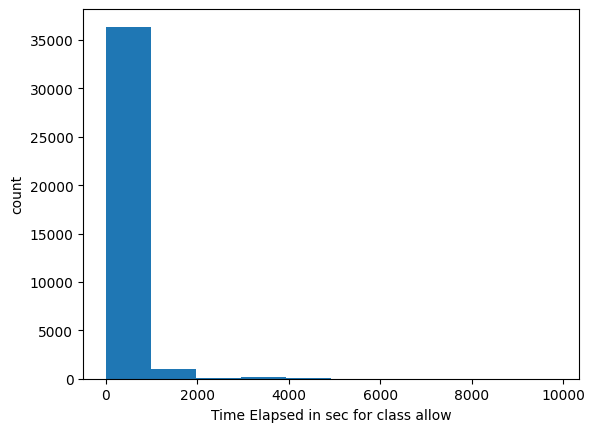

In [167]:
plt.xlabel("Time Elapsed in sec for class allow")
plt.ylabel("count")
plt.hist(allow_df['elapsed_time_(sec)'])


In the allow class where there is successful connection establishede, we  see that most values are around 1000 seconds, with small number of points having a time elapsed value of 2000 seconds and 4000 seconds

(array([1.4985e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

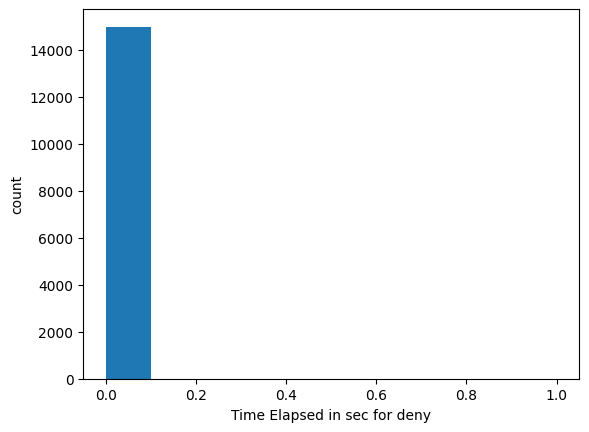

In [168]:
plt.xlabel("Time Elapsed in sec for deny")
plt.ylabel("count")
plt.hist(deny_df['elapsed_time_(sec)'])

In the deny class where the packets are either discarded or rejected, we  see that most values are around 0.1 seconds

(array([    0.,     0.,     0.,     0.,     0., 12851.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

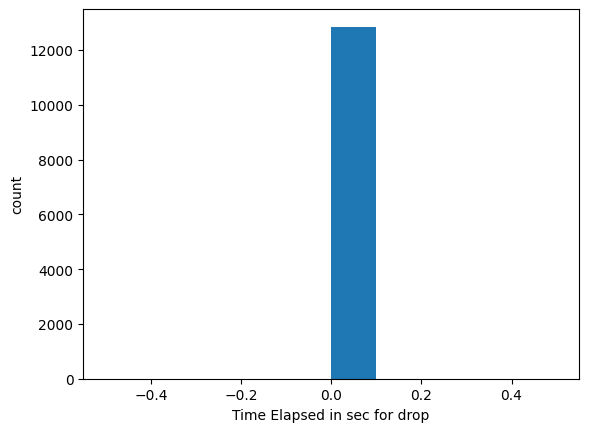

In [ ]:
plt.xlabel("Time Elapsed in sec for drop")
plt.ylabel("count")
plt.hist(drop_df['elapsed_time_(sec)'])

Again when there is a drop the packet is discarded with no response. With most of values having a time elapsed of 0.1 seconds

(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

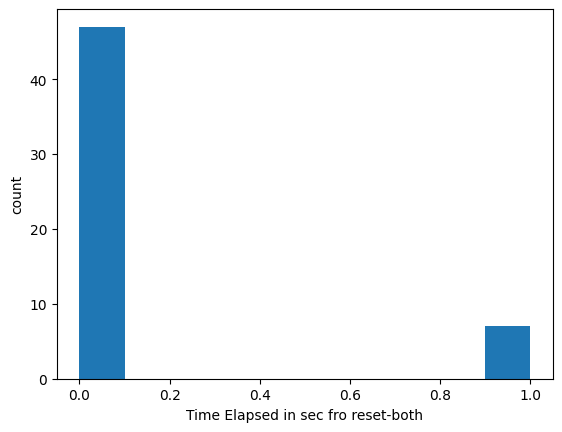

In [ ]:
plt.xlabel("Time Elapsed in sec fro reset-both")
plt.ylabel("count")
plt.hist(reset_df['elapsed_time_(sec)'])

reset-both is an action that sends a TCP RST (Reset) packet to both the source and the destination of a connection — effectively forcing both ends to immediately terminate the connection.

During the reset action we see that most of the time taken is around 0.1 seconds, with a few points taking a time of 1 second


In [169]:
firewall_data.columns

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_(sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

T-SNE representation of the data


In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

X = MinMaxScaler().fit_transform(firewall_data[['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port' , 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_(sec)', 'pkts_sent',
       'pkts_received']])
y = firewall_data['action'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 65532 samples in 0.192s...
[t-SNE] Computed neighbors for 65532 samples in 8.408s...
[t-SNE] Computed conditional probabilities for sample 1000 / 65532
[t-SNE] Computed conditional probabilities for sample 2000 / 65532
[t-SNE] Computed conditional probabilities for sample 3000 / 65532
[t-SNE] Computed conditional probabilities for sample 4000 / 65532
[t-SNE] Computed conditional probabilities for sample 5000 / 65532
[t-SNE] Computed conditional probabilities for sample 6000 / 65532
[t-SNE] Computed conditional probabilities for sample 7000 / 65532
[t-SNE] Computed conditional probabilities for sample 8000 / 65532
[t-SNE] Computed conditional probabilities for sample 9000 / 65532
[t-SNE] Computed conditional probabilities for sample 10000 / 65532
[t-SNE] Computed conditional probabilities for sample 11000 / 65532
[t-SNE] Computed conditional probabilities for sample 12000 / 65532
[t-SNE] Computed conditional probabilities for sam

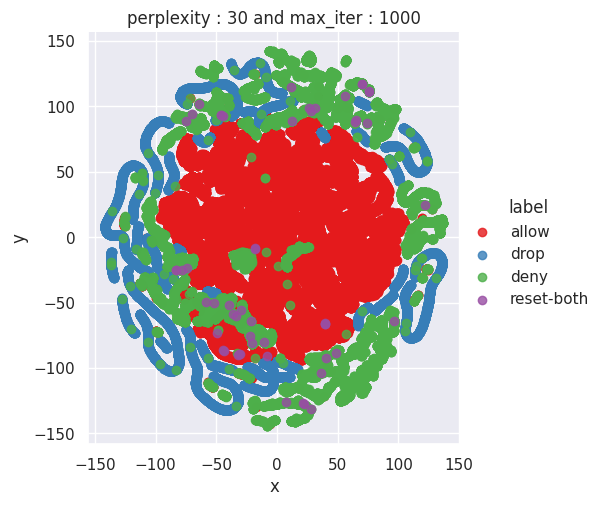

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, palette="Set1")
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

Here we are looking at the 2 dimensional representation of the data.

From this it is clear that most of the points of the allow class are well seperable from the other classes.

While the drop, deny and reset labels are somewhat mixed up

In [ ]:
firewall_data.columns


Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port', 'action', 'bytes', 'bytes_sent',
       'bytes_received', 'packets', 'elapsed_time_(sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

<h3> Feature engineering and Feature Selection </h3>

Port Difference

What is port diffrence ?

Computed as source port - nat source port (can also be applied to destination ports), the port diffrence is an indicator of if the nat is activated.

A diffrence value beyond a certain threshold could also imply a nat strategy

In [170]:
firewall_data['source_port_difference'] = abs(firewall_data['source_port'] - firewall_data['nat_source_port'])
firewall_data['destination_port_difference'] = abs(firewall_data['destination_port'] - firewall_data['nat_destination_port'])

Port Types

Based on the range of the source port and the destination port we classify them to either "well-known","registered" or "dynamic"

0–1023 -> well known
1024–49151 -> registered
49152–65535 -> dynamic

In [171]:
source_port_type = []
destination_port_type = []

for src_port in tqdm(firewall_data['source_port'].values):
  # print("source port is ",src_port)
  if src_port in range(0,1024):
    source_port_type.append("well_known")
  elif src_port in range(1024,49152):
    source_port_type.append("registered")
  elif src_port in range(49152,65536):
    source_port_type.append("dynamic")


for dest_port in tqdm(firewall_data['destination_port'].values):
  # print("source port is ",src_port)
  if dest_port in range(0,1024):
    destination_port_type.append("well_known")
  elif dest_port in range(1024,49152):
    destination_port_type.append("registered")
  elif dest_port in range(49152,65536):
    destination_port_type.append("dynamic")


firewall_data['source_port_type'] = source_port_type
firewall_data['destination_port_type'] = destination_port_type

100%|██████████| 65529/65529 [01:04<00:00, 1021.74it/s]


Port Symmetry -

What is port symmetry ?

when the source port is same as the destination port, then we say that ports are symmetric in nature. While in  symmetric ports could be normal when testing application reusing the ports.

However this could get suspicious when used as an evasion technique to confuse port confuse port-based firewalls or in malicious traffic.

In [172]:
source_dest_port_symm = []
nat_src_dest_port_symm = []

for row_index in tqdm(firewall_data.index):
  if firewall_data.loc[row_index,'source_port'] == firewall_data.loc[row_index,'destination_port']:
    source_dest_port_symm.append(1)
  else:
    source_dest_port_symm.append(0)



for row_index in tqdm(firewall_data.index):
  if firewall_data.loc[row_index,'nat_source_port'] == firewall_data.loc[row_index,'nat_destination_port']:
    nat_src_dest_port_symm.append(1)
  else:
    nat_src_dest_port_symm.append(0)


firewall_data['source_dest_port_symm'] = source_dest_port_symm
firewall_data['nat_src_dest_port_symm'] = nat_src_dest_port_symm


100%|██████████| 65529/65529 [00:01<00:00, 61661.69it/s]


Port match flags

What is port match flags?

when the source port number is same as the destination port number then we say that ports match. This can be applied to the destination ports as well.

It means the NAT device (e.g., firewall or router) did not change the source port.NAT has no conflict and can preserve the original port.
he NAT/firewall is set to preserve ports when possible.

Also in a low traffic scenario there will not be need for translation.

Sudden change in ports or lack of change could mean evasion or misconfiguration.

Here same ports are flagged as 1 else 0

In [173]:
source_port_match_flag = []
dest_port_match_flag = []


for row_index in tqdm(firewall_data.index):
  if firewall_data.loc[row_index,'source_port'] != firewall_data.loc[row_index,'nat_source_port']:
    source_port_match_flag.append(1)
  else:
    source_port_match_flag.append(0)



for row_index in tqdm(firewall_data.index):
  if firewall_data.loc[row_index,'destination_port'] != firewall_data.loc[row_index,'nat_destination_port']:
    dest_port_match_flag.append(1)
  else:
    dest_port_match_flag.append(0)


firewall_data['source_port_match_flag'] = source_port_match_flag
firewall_data['dest_port_match_flag'] = dest_port_match_flag



100%|██████████| 65529/65529 [00:01<00:00, 61838.17it/s]


In [26]:
firewall_data.head()

,source_port,destination_port,nat_source_port,nat_destination_port,action,bytes,bytes_sent,bytes_received,packets,elapsed_time_(sec),pkts_sent,pkts_received,source_port_difference,destination_port_difference,source_port_type,destination_port_type,source_dest_port_symm,nat_src_dest_port_symm,source_port_match_flag,dest_port_match_flag
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,2635,0,dynamic,well_known,0,0,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,0,0,dynamic,registered,0,0,0,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,36384,0,registered,dynamic,0,0,1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,0,0,dynamic,registered,0,0,0,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,4154,0,dynamic,well_known,0,0,1,0


In [174]:
firewall_data.shape

(65529, 20)

Note -

Columns such as source port, destination port, nat source port and nat destination ports are id's used to identify the parties betwenn whom the connection must be established. They cannot be considered as meaningful numberes in itself.
A port value 0f 1000 cannot be considered less then another port value of 1112.

Hence using these columns, features such as port diffrence,port range, port match flag and port symmetry are extracted and the actual port values are later dropped from the features list

In [175]:
final_firewall_data_df = firewall_data.drop(['source_port','destination_port','nat_source_port','nat_destination_port'],axis = 1)

In [176]:
final_firewall_data_df.head()

,action,bytes,bytes_sent,bytes_received,packets,elapsed_time_(sec),pkts_sent,pkts_received,source_port_difference,destination_port_difference,source_port_type,destination_port_type,source_dest_port_symm,nat_src_dest_port_symm,source_port_match_flag,dest_port_match_flag
0,allow,177,94,83,2,30,1,1,2635,0,dynamic,well_known,0,0,1,0
1,allow,4768,1600,3168,19,17,10,9,0,0,dynamic,registered,0,0,0,0
2,allow,238,118,120,2,1199,1,1,36384,0,registered,dynamic,0,0,1,0
3,allow,3327,1438,1889,15,17,8,7,0,0,dynamic,registered,0,0,0,0
4,allow,25358,6778,18580,31,16,13,18,4154,0,dynamic,well_known,0,0,1,0


In [177]:
final_firewall_data_df.columns

Index(['action', 'bytes', 'bytes_sent', 'bytes_received', 'packets',
       'elapsed_time_(sec)', 'pkts_sent', 'pkts_received',
       'source_port_difference', 'destination_port_difference',
       'source_port_type', 'destination_port_type', 'source_dest_port_symm',
       'nat_src_dest_port_symm', 'source_port_match_flag',
       'dest_port_match_flag'],
      dtype='object')

In [178]:
#gather all the data
X_data = final_firewall_data_df.loc[:,['bytes', 'bytes_sent', 'bytes_received', 'packets',
       'elapsed_time_(sec)', 'pkts_sent', 'pkts_received',
       'source_port_difference', 'destination_port_difference',
       'source_port_type', 'destination_port_type', 'source_port_match_flag',
       'dest_port_match_flag', 'source_dest_port_symm',
       'nat_src_dest_port_symm']]

encoder = LabelEncoder() #label encode the target label
y_data = encoder.fit_transform(final_firewall_data_df['action'])
#perfrom the train,test and cross validation split of the overall data
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,stratify = y_data,test_size=0.10,random_state = 2)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,stratify = y_train,test_size=0.10,random_state = 2)

print("X_train shape ",X_train.shape)
print("y_train shape ",y_train.shape)
print("X_test shape ",X_test.shape)
print("y_test shape ",y_test.shape)

X_train shape  (58976, 15)
y_train shape  (58976,)
X_test shape  (6553, 15)
y_test shape  (6553,)


In [179]:
#check the label encoding on the target class
encoder_check = pd.DataFrame({'class':firewall_data['action'],'mapping':y_data})
print("mapping value for allow ",encoder_check[encoder_check['class'] == 'allow']['mapping'].unique())
print("mapping value for deny ",encoder_check[encoder_check['class'] == 'deny']['mapping'].unique())
print("mapping value for drop ",encoder_check[encoder_check['class'] == 'drop']['mapping'].unique())
print("mapping value for reset-both ",encoder_check[encoder_check['class'] == 'reset-both']['mapping'].unique())

mapping value for allow  [0]
mapping value for deny  [1]
mapping value for drop  [2]
mapping value for reset-both  [3]


In [180]:
label_mapping = dict(zip(['allow','deny','drop','reset-both'],[0,1,2,3]))

Encode the data appropriately based on th e type before applying on the model.

1. categorical data is count vectorised
2. numerical data is normalised
3. binary data is left as is

In [181]:
src_port_type_vec = CountVectorizer()
src_port_type_vec.fit(X_tr['source_port_type'])
src_port_type_vec_tr = src_port_type_vec.transform(X_tr['source_port_type'])
src_port_type_vec_cv = src_port_type_vec.transform(X_cv['source_port_type'])
src_port_type_vec_test = src_port_type_vec.transform(X_test['source_port_type'])

dest_port_type_vec = CountVectorizer()
dest_port_type_vec.fit(X_tr['destination_port_type'])
dest_port_type_vec_tr = dest_port_type_vec.transform(X_tr['destination_port_type'])
dest_port_type_vec_cv = dest_port_type_vec.transform(X_cv['destination_port_type'])
dest_port_type_vec_test = dest_port_type_vec.transform(X_test['destination_port_type'])

normaliser = Normalizer()
norm_bytes_tr = normaliser.fit_transform(X_tr['bytes'].values.reshape(1,-1))
norm_bytes_cv = normaliser.fit_transform(X_cv['bytes'].values.reshape(1,-1))
norm_bytes_test = normaliser.fit_transform(X_test['bytes'].values.reshape(1,-1))
norm_bytes_tr = norm_bytes_tr.reshape(norm_bytes_tr.shape[1],-1)
norm_bytes_cv = norm_bytes_cv.reshape(norm_bytes_cv.shape[1],-1)
norm_bytes_test = norm_bytes_test.reshape(norm_bytes_test.shape[1],-1)
# norm_bytes_tr_csr = sparse.csr_matrix(norm_bytes_tr)
# norm_bytes_test_csr = sparse.csr_matrix(norm_bytes_test)

norm_bytes_sent_tr = normaliser.fit_transform(X_tr['bytes_sent'].values.reshape(1,-1))
norm_bytes_sent_cv = normaliser.fit_transform(X_cv['bytes_sent'].values.reshape(1,-1))
norm_bytes_sent_test = normaliser.fit_transform(X_test['bytes_sent'].values.reshape(1,-1))
norm_bytes_sent_tr = norm_bytes_sent_tr.reshape(norm_bytes_sent_tr.shape[1],-1)
norm_bytes_sent_cv = norm_bytes_sent_cv.reshape(norm_bytes_sent_cv.shape[1],-1)
norm_bytes_sent_test = norm_bytes_sent_test.reshape(norm_bytes_sent_test.shape[1],-1)
# norm_bytes_sent_tr_csr = sparse.csr_matrix(norm_bytes_sent_tr)
# norm_bytes_sent_test_csr = sparse.csr_matrix(norm_bytes_sent_test)

norm_bytes_received_tr = normaliser.fit_transform(X_tr['bytes_received'].values.reshape(1,-1))
norm_bytes_received_cv = normaliser.fit_transform(X_cv['bytes_received'].values.reshape(1,-1))
norm_bytes_received_test = normaliser.fit_transform(X_test['bytes_received'].values.reshape(1,-1))
norm_bytes_received_tr = norm_bytes_received_tr.reshape(norm_bytes_received_tr.shape[1],-1)
norm_bytes_received_cv = norm_bytes_received_cv.reshape(norm_bytes_received_cv.shape[1],-1)
norm_bytes_received_test = norm_bytes_received_test.reshape(norm_bytes_received_test.shape[1],-1)
# norm_bytes_received_tr_csr = sparse.csr_matrix(norm_bytes_received_tr)
# norm_bytes_received_test_csr = sparse.csr_matrix(norm_bytes_received_test)

norm_pkts_tr = normaliser.fit_transform(X_tr['packets'].values.reshape(1,-1))
norm_pkts_cv = normaliser.fit_transform(X_cv['packets'].values.reshape(1,-1))
norm_pkts_test = normaliser.fit_transform(X_test['packets'].values.reshape(1,-1))
norm_pkts_tr = norm_pkts_tr.reshape(norm_pkts_tr.shape[1],-1)
norm_pkts_cv = norm_pkts_cv.reshape(norm_pkts_cv.shape[1],-1)
norm_pkts_test = norm_pkts_test.reshape(norm_pkts_test.shape[1],-1)
# norm_pkts_tr_csr = sparse.csr_matrix(norm_pkts_tr)
# norm_pkts_test_csr = sparse.csr_matrix(norm_pkts_test)


norm_pkts_sent_tr = normaliser.fit_transform(X_tr['pkts_sent'].values.reshape(1,-1))
norm_pkts_sent_cv = normaliser.fit_transform(X_cv['pkts_sent'].values.reshape(1,-1))
norm_pkts_sent_test = normaliser.fit_transform(X_test['pkts_sent'].values.reshape(1,-1))
norm_pkts_sent_tr = norm_pkts_sent_tr.reshape(norm_pkts_sent_tr.shape[1],-1)
norm_pkts_sent_cv = norm_pkts_sent_cv.reshape(norm_pkts_sent_cv.shape[1],-1)
norm_pkts_sent_test = norm_pkts_sent_test.reshape(norm_pkts_sent_test.shape[1],-1)
# norm_pkts_sent_tr_csr = sparse.csr_matrix(norm_pkts_sent_tr)
# norm_pkts_sent_test_csr = sparse.csr_matrix(norm_pkts_sent_test)

norm_pkts_received_tr = normaliser.fit_transform(X_tr['pkts_received'].values.reshape(1,-1))
norm_pkts_received_cv = normaliser.fit_transform(X_cv['pkts_received'].values.reshape(1,-1))
norm_pkts_received_test = normaliser.fit_transform(X_test['pkts_received'].values.reshape(1,-1))
norm_pkts_received_tr = norm_pkts_received_tr.reshape(norm_pkts_received_tr.shape[1],-1)
norm_pkts_received_cv = norm_pkts_received_cv.reshape(norm_pkts_received_cv.shape[1],-1)
norm_pkts_received_test = norm_pkts_received_test.reshape(norm_pkts_received_test.shape[1],-1)
# norm_pkts_received_tr_csr = sparse.csr_matrix(norm_pkts_received_tr)
# norm_pkts_received_test_csr = sparse.csr_matrix(norm_pkts_received_test)

norm_elapsed_time_tr = normaliser.fit_transform(X_tr['elapsed_time_(sec)'].values.reshape(1,-1))
norm_elapsed_time_cv = normaliser.fit_transform(X_cv['elapsed_time_(sec)'].values.reshape(1,-1))
norm_elapsed_time_test = normaliser.fit_transform(X_test['elapsed_time_(sec)'].values.reshape(1,-1))
norm_elapsed_time_tr = norm_elapsed_time_tr.reshape(norm_elapsed_time_tr.shape[1],-1)
norm_elapsed_time_cv = norm_elapsed_time_cv.reshape(norm_elapsed_time_cv.shape[1],-1)
norm_elapsed_time_test = norm_elapsed_time_test.reshape(norm_elapsed_time_test.shape[1],-1)
# norm_elapsed_time_tr_csr = sparse.csr_matrix(norm_elapsed_time_tr)
# norm_elapsed_time_test_csr = sparse.csr_matrix(norm_elapsed_time_test)

norm_source_port_difference_tr = normaliser.fit_transform(X_tr['source_port_difference'].values.reshape(1,-1))
norm_source_port_difference_cv = normaliser.fit_transform(X_cv['source_port_difference'].values.reshape(1,-1))
norm_source_port_difference_test = normaliser.fit_transform(X_test['source_port_difference'].values.reshape(1,-1))
norm_source_port_difference_tr = norm_source_port_difference_tr.reshape(norm_source_port_difference_tr.shape[1],-1)
norm_source_port_difference_cv = norm_source_port_difference_cv.reshape(norm_source_port_difference_cv.shape[1],-1)
norm_source_port_difference_test = norm_source_port_difference_test.reshape(norm_source_port_difference_test.shape[1],-1)


norm_destination_port_difference_tr = normaliser.fit_transform(X_tr['destination_port_difference'].values.reshape(1,-1))
norm_destination_port_difference_cv = normaliser.fit_transform(X_cv['destination_port_difference'].values.reshape(1,-1))
norm_destination_port_difference_test = normaliser.fit_transform(X_test['destination_port_difference'].values.reshape(1,-1))
norm_destination_port_difference_tr = norm_destination_port_difference_tr.reshape(norm_destination_port_difference_tr.shape[1],-1)
norm_destination_port_difference_cv = norm_destination_port_difference_cv.reshape(norm_destination_port_difference_cv.shape[1],-1)
norm_destination_port_difference_test = norm_destination_port_difference_test.reshape(norm_destination_port_difference_test.shape[1],-1)

source_dest_port_sym_tr = X_tr['source_dest_port_symm'].values.reshape(-1,1)
source_dest_port_sym_cv = X_cv['source_dest_port_symm'].values.reshape(-1,1)
source_dest_port_sym_test = X_test['source_dest_port_symm'].values.reshape(-1,1)

nat_source_dest_port_sym_tr = X_tr['nat_src_dest_port_symm'].values.reshape(-1,1)
nat_source_dest_port_sym_cv = X_cv['nat_src_dest_port_symm'].values.reshape(-1,1)
nat_source_dest_port_sym_test = X_test['nat_src_dest_port_symm'].values.reshape(-1,1)


source_port_match_flag_tr = X_tr['source_port_match_flag'].values.reshape(-1,1)
source_port_match_flag_cv = X_cv['source_port_match_flag'].values.reshape(-1,1)
source_port_match_flag_test = X_test['source_port_match_flag'].values.reshape(-1,1)

dest_port_match_flag_tr = X_tr['dest_port_match_flag'].values.reshape(-1,1)
dest_port_match_flag_cv = X_cv['dest_port_match_flag'].values.reshape(-1,1)
dest_port_match_flag_test = X_test['dest_port_match_flag'].values.reshape(-1,1)

In [182]:
from scipy import sparse

combine all the transformed data using hstack

In [183]:
train_data_processed = sparse.hstack((src_port_type_vec_tr,dest_port_type_vec_tr,norm_bytes_tr,norm_bytes_sent_tr,norm_bytes_received_tr,norm_pkts_tr,norm_pkts_sent_tr,norm_pkts_received_tr,norm_elapsed_time_tr,norm_source_port_difference_tr,norm_destination_port_difference_tr,source_dest_port_sym_tr,nat_source_dest_port_sym_tr,source_port_match_flag_tr,dest_port_match_flag_tr))
cv_data_processed = sparse.hstack((src_port_type_vec_cv,dest_port_type_vec_cv,norm_bytes_cv,norm_bytes_sent_cv,norm_bytes_received_cv,norm_pkts_cv,norm_pkts_sent_cv,norm_pkts_received_cv,norm_elapsed_time_cv,norm_source_port_difference_cv,norm_destination_port_difference_cv,source_dest_port_sym_cv,nat_source_dest_port_sym_cv,source_port_match_flag_cv,dest_port_match_flag_cv))
test_data_processed  = sparse.hstack((src_port_type_vec_test,dest_port_type_vec_test,norm_bytes_test,norm_bytes_sent_test,norm_bytes_received_test,norm_pkts_test,norm_pkts_sent_test,norm_pkts_received_test,norm_elapsed_time_test,norm_source_port_difference_test,norm_destination_port_difference_test,source_dest_port_sym_test,nat_source_dest_port_sym_test,source_port_match_flag_test,dest_port_match_flag_test))


<h1> Performance Metric </h1>





Log Loss

Please refer https://miro.medium.com/v2/resize:fit:1162/0*i2_eUc_t8A1EJObd.png for the formula of log loss

Note - The log(p) term within the log loss formula penalises misclassification or lower values of probabbility.

The probabilistic outcomes help in comparing multiple models.

Lower the log loss beterr the model

In addition to log loss, confusion matrix is used on the final test prediction to find the number of correctly classified points

<h1> Model Building </h1>

<h2> Random Model</h2>

A random model that arbitarily assign probability score is built.

This model will be used to compare the performance with other models in the future.

In [186]:

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
import random
np.random.seed = 12
test_len  = y_test.shape[0]
predicted_y = np.zeros((test_len,4))
for i in range(test_len):
    rand_probs = np.random.rand(1,4)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y))

predicted_y =np.argmax(predicted_y, axis=1)




Log loss on Test Data using Random Model 1.6411302703331787


Text(50.722222222222214, 0.5, 'Actual class')

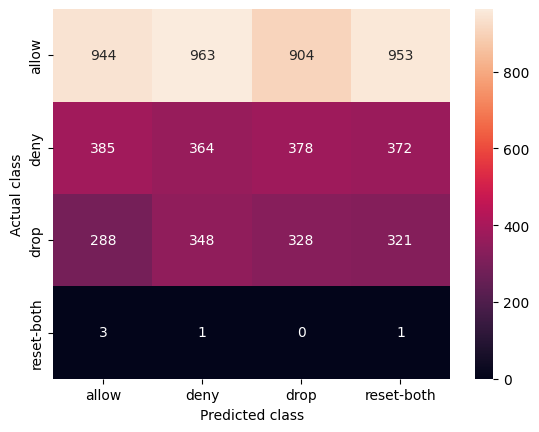

In [187]:
#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(y_test,predicted_y),annot = True,fmt = 'g',xticklabels=label_mapping.keys(),yticklabels=label_mapping.keys())
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

<h2> KNearestNeighbors </h2>

1. KNN is based on the concept of neighborhood. Points are alike those  
   points in the nearest neighbourhood.
2. We use GridsearchCV to look at various value of hyperparameter k to
   decide on the best value


In [189]:
params = {'n_neighbors':[1,5,9,11,15,25]}
knn = KNeighborsClassifier()
gd_clf_knn = GridSearchCV(knn,param_grid=params)
gd_clf_knn.fit(train_data_processed,y_tr)
print("the best estimator is ")
print(gd_clf_knn.best_params_)

the best estimator is 
{'n_neighbors': 1}


Log loss on the train data is  0.010865112743997252
Log loss on the cv data is  0.4216704109611876
Log loss on the test data is  0.3520210311160536


Text(50.722222222222214, 0.5, 'Actual class')

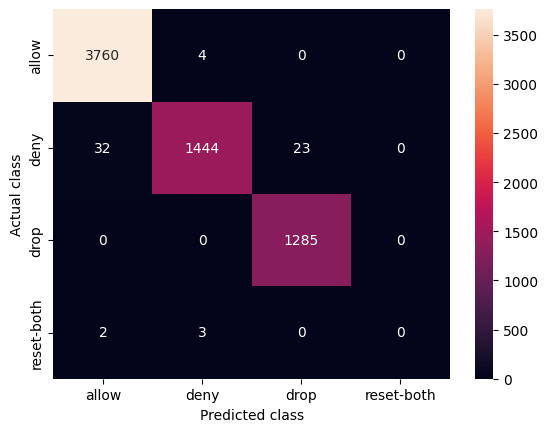

In [190]:
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(train_data_processed,y_tr)
y_train_pred_proba = knn_model.predict_proba(train_data_processed)
y_cv_pred_proba = knn_model.predict_proba(cv_data_processed)
y_test_pred_proba = knn_model.predict_proba(test_data_processed)

knn_train_log_loss = log_loss(y_tr,y_train_pred_proba)
knn_cv_log_loss = log_loss(y_cv,y_cv_pred_proba)
knn_test_log_loss = log_loss(y_test,y_test_pred_proba)


print("Log loss on the train data is ",knn_train_log_loss)
print("Log loss on the cv data is ",knn_cv_log_loss)
print("Log loss on the test data is ",knn_test_log_loss)

knn_test_pred = knn_model.predict(test_data_processed)

#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(y_test,knn_test_pred),annot = True,fmt = 'g',xticklabels=label_mapping.keys(),yticklabels=label_mapping.keys())
plt.xlabel("Predicted class")
plt.ylabel("Actual class")


The KNN had the best parameter as k = 1.

Also the log loss on the test data with KNN is 0.35 while the log loss of the test data on the random model is 1.64.

It is clearly evident that KNN has reduced log loss.



---------------------------------------------------------------------------

<h2> Logistic Regression</2>

In this model, we try to minimise the log loss i.e

log(1+exp(-y_i w_T x_i)) also adding the regularization parameter C.

Here C is the hyperparameter with L2 regularization

In [102]:
params = {'C':[0.0001,0.001,0.01,0.1,1,10,100]}
log_reg = LogisticRegression(class_weight='balanced',random_state=12)
gd_clf2 = GridSearchCV(log_reg,param_grid=params,scoring = 'neg_log_loss',cv = 3,return_train_score = True)
gd_clf2.fit(train_data_processed,y_tr)
print("the best parameters are ",gd_clf2.best_params_)

the best parameters are  {'C': 10}


In [104]:
params_df = pd.DataFrame(gd_clf2.cv_results_['params'])
cv_score_df  = pd.DataFrame(gd_clf2.cv_results_).loc[:,['mean_test_score','mean_train_score']]

param_cv_df  = pd.merge(params_df,cv_score_df,left_index=True,right_index=True)
param_cv_df['mean_test_score']  = param_cv_df['mean_test_score'] * (-1)
param_cv_df['mean_train_score']  = param_cv_df['mean_train_score'] * (-1)

print(param_cv_df)

          C  mean_test_score  mean_train_score
0    0.0001         0.902330          0.902299
1    0.0010         0.401298          0.401391
2    0.0100         0.236069          0.236238
3    0.1000         0.203297          0.203372
4    1.0000         0.196819          0.196707
5   10.0000         0.196297          0.196078
6  100.0000         0.196659          0.196477


We observe variation in the log loss of cross validation data for diffrent value of C

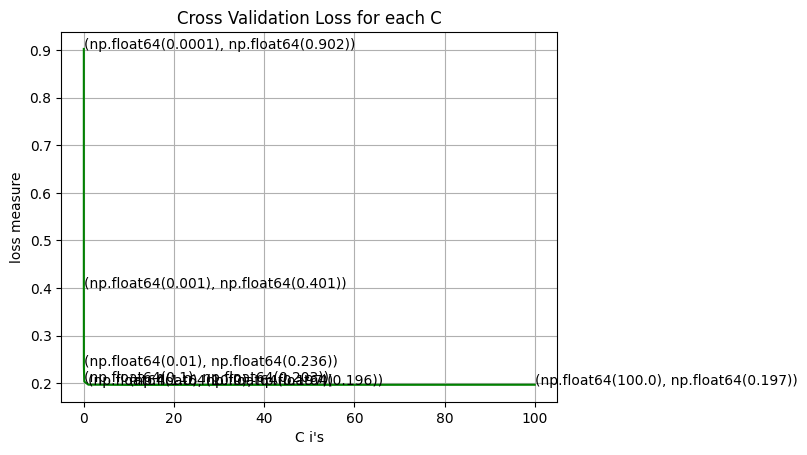

In [106]:
fig, ax = plt.subplots()
ax.plot(param_cv_df['C'], param_cv_df['mean_test_score'],c='g')
for i, txt in enumerate(np.round(param_cv_df['mean_test_score'],3)):
    ax.annotate((param_cv_df['C'].values[i],np.round(txt,3)), (param_cv_df['C'].values[i],param_cv_df['mean_test_score'].values[i]))
plt.grid()
plt.title("Cross Validation Loss for each C")
plt.xlabel("C i's")
plt.ylabel("loss measure")
plt.show()

Log loss on the train data is  0.198753475362262
Log loss on the cv data is  0.20144012029145716
Log loss on the test data is  0.19175865447174875


Text(50.722222222222214, 0.5, 'Actual class')

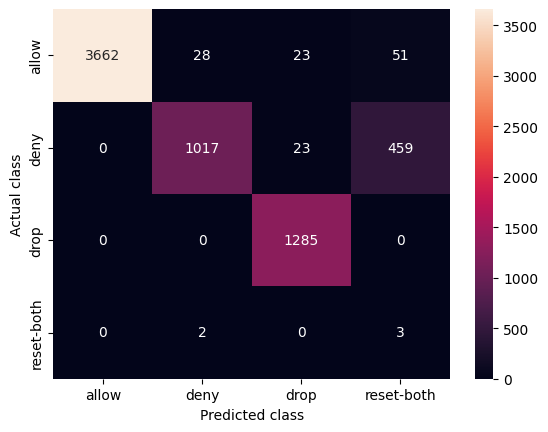

In [103]:
log_reg = LogisticRegression(C = 10,penalty='l2',class_weight = 'balanced',random_state = 12)
log_reg.fit(train_data_processed,y_tr)
y_train_pred_proba = log_reg.predict_proba(train_data_processed)
y_cv_pred_proba = log_reg.predict_proba(cv_data_processed)
y_test_pred_proba = log_reg.predict_proba(test_data_processed)

log_reg_train_log_loss = log_loss(y_tr,y_train_pred_proba)
log_reg_cv_log_loss = log_loss(y_cv,y_cv_pred_proba)
log_reg_test_log_loss = log_loss(y_test,y_test_pred_proba)


print("Log loss on the train data is ",log_reg_train_log_loss)
print("Log loss on the cv data is ",log_reg_cv_log_loss)
print("Log loss on the test data is ",log_reg_test_log_loss)

log_reg_test_pred = log_reg.predict(test_data_processed)

#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(y_test,log_reg_test_pred),annot = True,fmt = 'g',xticklabels=label_mapping.keys(),yticklabels=label_mapping.keys())
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

A test log loss of 0.1 is observed, with most of the values from all the classes bieng correctly classified.

With some data points from the deny is bieng misclassified as reset-both.

Also it can be seen that no point belonging to drop, deny or reset has been misclassified as allow.

---------------------------------------------------------------------------

<h3> Random Forest Classifier </h3>

is an ensemble based model.

Here we use the number of base learners, the depth of the tree and information gain computation either by gini impurity or entropy as  hyperparameters

In [108]:
# tuning the hyperparameters on training data
random_forest_params = {'n_estimators': [15,50,100,250,500,1000,2000], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 12, 20, 25,30,50]}
rf_model = RandomForestClassifier(class_weight = 'balanced',  random_state =12)
random_search_rf = RandomizedSearchCV(estimator = rf_model, param_distributions = random_forest_params,scoring = 'neg_log_loss', random_state = 12,return_train_score=True)
random_search_rf.fit(train_data_processed, y_tr)
print("the best parameters in random forest are ",random_search_rf.best_params_)


the best parameters in random forest are  {'n_estimators': 1000, 'max_depth': 12, 'criterion': 'gini'}


In [110]:
params_df = pd.DataFrame(random_search_rf.cv_results_['params'])
cv_score_df  = pd.DataFrame(random_search_rf.cv_results_).loc[:,['mean_test_score','mean_train_score']]

param_cv_df  = pd.merge(params_df,cv_score_df,left_index=True,right_index=True)
param_cv_df['mean_test_score']  = param_cv_df['mean_test_score'] * (-1)
param_cv_df['mean_train_score']  = param_cv_df['mean_train_score'] * (-1)

print(param_cv_df)

   n_estimators  max_depth criterion  mean_test_score  mean_train_score
0           250         20      gini         0.023059          0.001515
1          1000         20      gini         0.020630          0.001518
2           100         10   entropy         0.024618          0.019842
3          1000         10   entropy         0.023728          0.019469
4          1000         12      gini         0.015962          0.009982
5            50         12      gini         0.017865          0.010201
6           250         30   entropy         0.028904          0.001457
7           100         25      gini         0.030114          0.001470
8            15         20      gini         0.036976          0.001641
9            15         12      gini         0.019147          0.009796


In [111]:
y_test

array([0, 0, 1, ..., 1, 1, 2])

Log loss on the train data is  0.01199089158011372
Log loss on the cv data is  0.4952879019623049
Log loss on the test data is  0.49552218279472693


Text(50.722222222222214, 0.5, 'Actual class')

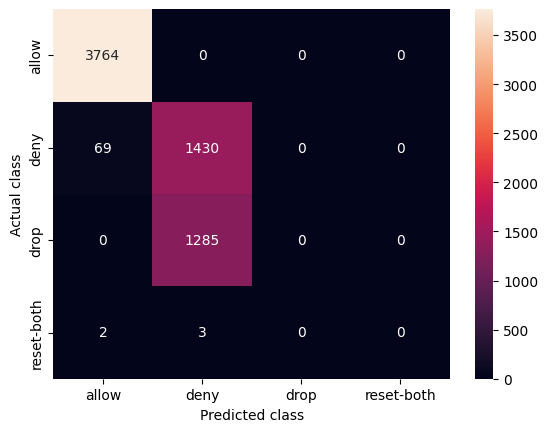

In [112]:
rf_clf = RandomForestClassifier(n_estimators = 1000,max_depth = 12,criterion = 'gini',class_weight = 'balanced',  random_state = 12)
rf_clf.fit(train_data_processed,y_tr)
y_train_pred_proba = rf_clf.predict_proba(train_data_processed)
y_cv_pred_proba = rf_clf.predict_proba(cv_data_processed)
y_test_pred_proba = rf_clf.predict_proba(test_data_processed)

rf_clf_train_log_loss = log_loss(y_tr,y_train_pred_proba)
rf_clf_cv_log_loss = log_loss(y_cv,y_cv_pred_proba)
rf_clf_test_log_loss = log_loss(y_test,y_test_pred_proba)


print("Log loss on the train data is ",rf_clf_train_log_loss)
print("Log loss on the cv data is ",rf_clf_cv_log_loss)
print("Log loss on the test data is ",rf_clf_test_log_loss)

rf_clf_test_pred = rf_clf.predict(test_data_processed)

#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion_matrix(y_test,rf_clf_test_pred),annot = True,fmt = 'g',xticklabels=label_mapping.keys(),yticklabels=label_mapping.keys())
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

A test log loss of 0.49 is observed.

However from the confusion matrix it is quite evident that, all of the points belonging to the drop class are bieng misclassified as deny.

Some of the points belonging to the deny class have been misclassfied as allow.

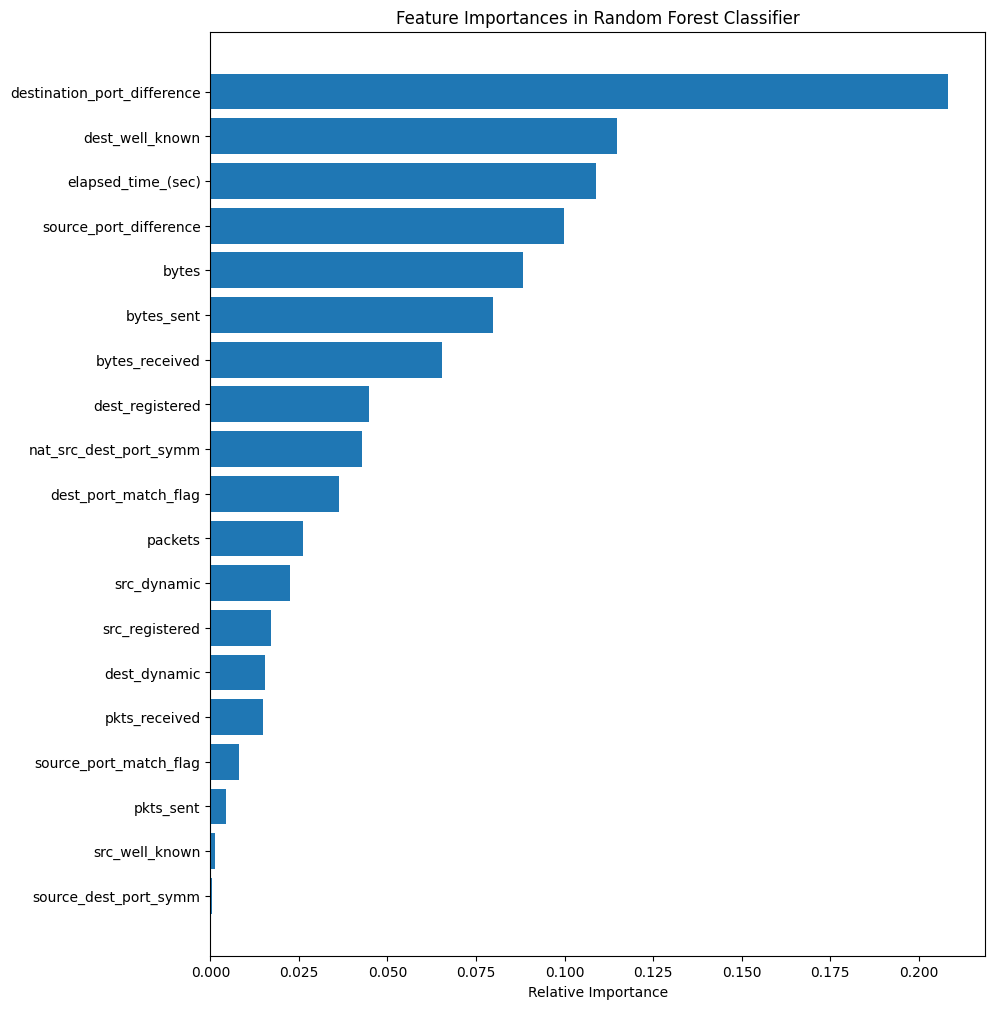

In [122]:
# list of features

features = ['src_dynamic','src_registered','src_well_known','dest_dynamic','dest_registered','dest_well_known','bytes', 'bytes_sent', 'bytes_received',
'packets','pkts_sent', 'pkts_received','elapsed_time_(sec)','source_port_difference', 'destination_port_difference','source_dest_port_symm','nat_src_dest_port_symm','source_port_match_flag',
'dest_port_match_flag']
# array of feature importances
importances = rf_clf.feature_importances_
# sorting indices of importances in decreasing order
indices = (np.argsort(importances))
# plotting the horizontal barplot
plt.figure(figsize=(10,12))
plt.title('Feature Importances in Random Forest Classifier')
plt.barh(range(len(indices)), importances[indices],  align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
!pip install xgboost

In [205]:
from xgboost import XGBClassifier

In [ ]:
# label_mapping = dict(zip(firewall_data['action'].unique(),[0,1,2,3]))

# train_labels = []
# for label in y_tr.values:
#   train_labels.append(label_mapping[label])

# cv_labels = []
# for label in y_cv.values:
#   cv_labels.append(label_mapping[label])

# test_labels = []
# for label in y_test.values:
#   test_labels.append(label_mapping[label])

In [126]:
num_models = [15,25,35,50,85,100,150]
shrinkage_coeff = [0.0001, 0.001, 0.01, 0.1, 1.0,10,100]
param_grid = {'learning_rate':shrinkage_coeff,'n_estimators' : num_models}
xgbc = XGBClassifier()

# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
rand_search_xgb = RandomizedSearchCV(xgbc, param_grid, scoring="neg_log_loss",  cv=3,return_train_score=True,random_state=12)
rand_search_xgb.fit(train_data_processed,y_tr)
print("the best parameters are ",rand_search_xgb.best_params_)

the best parameters are  {'n_estimators': 100, 'learning_rate': 0.1}


In [127]:
params_df = pd.DataFrame(rand_search_xgb.cv_results_['params'])
cv_score_df  = pd.DataFrame(rand_search_xgb.cv_results_).loc[:,['mean_test_score','mean_train_score']]

param_cv_df  = pd.merge(params_df,cv_score_df,left_index=True,right_index=True)
param_cv_df['mean_test_score']  = param_cv_df['mean_test_score'] * (-1)
param_cv_df['mean_train_score']  = param_cv_df['mean_train_score'] * (-1)

print(param_cv_df)

   n_estimators  learning_rate  mean_test_score  mean_train_score
0           100        100.000         0.032616          0.029507
1            50        100.000         0.032616          0.029507
2            15          0.001         1.356927          1.356920
3           100         10.000        12.467041         12.457154
4            15         10.000        12.467041         12.457154
5            15          1.000         0.009709          0.004274
6           150          0.010         0.251841          0.251382
7           100          0.100         0.009367          0.005325
8           100          0.010         0.423056          0.422764
9            25          0.001         1.337874          1.337863


Log loss on the train data is  0.005736801450297892
Log loss on the cv data is  0.05374102482520849
Log loss on the test data is  0.054675435682331824


Text(50.722222222222214, 0.5, 'Actual class')

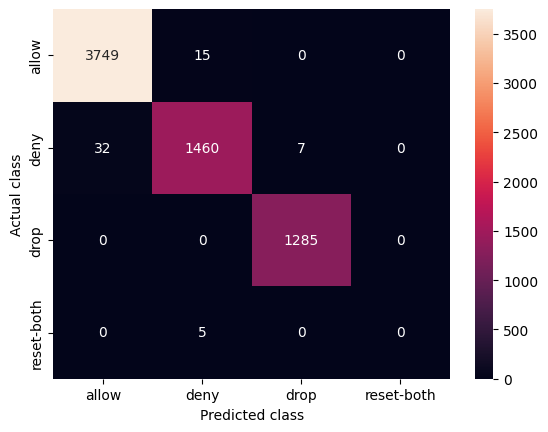

In [129]:
xgbc = XGBClassifier(n_estimators = 100,learning_rate = 0.1,criterion = 'gini',class_weight = 'balanced',  random_state = 12)
xgbc.fit(train_data_processed,y_tr)
y_train_pred_proba = xgbc.predict_proba(train_data_processed)
y_cv_pred_proba = xgbc.predict_proba(cv_data_processed)
y_test_pred_proba = xgbc.predict_proba(test_data_processed)

xgbc_train_log_loss = log_loss(y_tr,y_train_pred_proba)
xgbc_cv_log_loss = log_loss(y_cv,y_cv_pred_proba)
xgbc_test_log_loss = log_loss(y_test,y_test_pred_proba)


print("Log loss on the train data is ",xgbc_train_log_loss)
print("Log loss on the cv data is ",xgbc_cv_log_loss)
print("Log loss on the test data is ",xgbc_test_log_loss)

xgbc_test_pred = xgbc.predict(test_data_processed)

#https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
fig, ax = plt.subplots(1, 1)



sns.heatmap(confusion_matrix(y_test,xgbc_test_pred),annot = True,fmt = 'g',xticklabels=label_mapping.keys(),yticklabels=label_mapping.keys())
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

A train log loss of 0.005 and a cv log loss of 0.05 is observed.

The XGboost model is generalising well on the train data and fairly well on the cv data.
There is a small to medium generalization gap which is observed.

The reset class is misclassified as deny

Taking into account that classifying the given  network log into allow,deny,drop or reset is a low latency problem, we now need to explore the amount pf time that it takes for each of the models to make the classification given the test data point

In [225]:
import time

start_time = time.time()
knn_predict = knn_model.predict(test_data_processed.toarray()[0].reshape(1,-1))
end_time = time.time()
knn_test_time = end_time - start_time
print("time taken by the knn model ",knn_test_time)

start_time = time.time()
lgreg_predict = log_reg.predict(test_data_processed.toarray()[0].reshape(1,-1))
end_time = time.time()
lgreg_test_time = end_time - start_time
print("time taken by the log reg model ",lgreg_test_time)

start_time = time.time()
rf_clf_predict = rf_clf.predict(test_data_processed.toarray()[0].reshape(1,-1))
end_time = time.time()
rf_clf_test_time = end_time - start_time
print("time taken by the random forest model ",rf_clf_test_time)


start_time = time.time()
xgbc_predict = xgbc.predict(test_data_processed.toarray()[0].reshape(1,-1))
end_time = time.time()
xgbc_test_time = end_time - start_time
print("time taken by the XG Boost model ",xgbc_test_time)


time taken by the knn model  0.0085601806640625
time taken by the log reg model  0.0013697147369384766
time taken by the random forest model  0.2014327049255371
time taken by the XG Boost model  0.004265785217285156


In [194]:
!pip install prettytable

In [235]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model Name", "Train Log Loss", "CV Log Loss", "Test Log Loss","Test Time (seconds)"]
table.add_row(["KNN", round(knn_train_log_loss,5), round(knn_cv_log_loss,5), round(knn_test_log_loss,5),round(knn_test_time,5)])
table.add_row(["Logistic Regression", round(log_reg_train_log_loss,5), round(log_reg_cv_log_loss,5), round(log_reg_test_log_loss,5),round(lgreg_test_time,5)])
table.add_row(["Random Forest", round(rf_clf_train_log_loss,5), round(rf_clf_cv_log_loss,5), round(rf_clf_test_log_loss,5),round(rf_clf_test_time,5)])
table.add_row(["XG Boost", round(xgbc_train_log_loss,5), round(xgbc_cv_log_loss,5), round(xgbc_test_log_loss,5), round(xgbc_test_time,5)])

print(table)

+---------------------+----------------+-------------+---------------+---------------------+
|      Model Name     | Train Log Loss | CV Log Loss | Test Log Loss | Test Time (seconds) |
+---------------------+----------------+-------------+---------------+---------------------+
|         KNN         |    0.01087     |   0.42167   |    0.35202    |       0.00856       |
| Logistic Regression |    0.19875     |   0.20144   |    0.19176    |       0.00137       |
|    Random Forest    |    0.01199     |   0.49529   |    0.49552    |       0.20143       |
|       XG Boost      |    0.00574     |   0.05374   |    0.05468    |       0.00427       |
+---------------------+----------------+-------------+---------------+---------------------+


From the above table

1. Logistic regression and XGBoost models seem like a good fit.
2. However, in XGBoost it is noticed that some of the points marked as
   deny have been predicted as allow which can pose a security risk and lead to exploitation of vulnearble systems.
3. In case of Logistic regression such kind of errors cannot be noticed.

So, the ultimate model suitable here can be logistic regression.



<h3> References </h3>

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html

https://saturncloud.io/blog/how-to-show-an-image-in-google-colab/


https://miro.medium.com/v2/resize:fit:1162/0*i2_eUc_t8A1EJObd.png
https://pypi.org/project/prettytable/

https://stackoverflow.com/questions/37716699/how-to-hstack-several-sparse-matrices-feature-matrices

https://stackoverflow.com/questions/75717467/heatmap-for-confusion-matrix-that-is-sensitive-to-the-distance-to-the-left-diago

Crytography, Network Security and Cyber Laws by Bernanrd L Menenzes and Ravinder Kumar

